# Project 3: Natural Language Processing

## Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.tokenize import WordPunctTokenizer

## Gathering posts

In [2]:
# URL for the pushshift api

post_url = 'https://api.pushshift.io/reddit/search/submission'

In [3]:
# creates a function to pull posts from the api

def get_posts(url, subreddit, timespan):
    
    '''
    url: the API URL
    subreddit: the name of the subreddit (after r/) as a string
    timespan: the number of days into the past you want to collect posts
    '''
    
# create an empty data frame for posts to be added to
    df = pd.DataFrame()
    
# set standard parameters with the size == 100 and the subreddit
# set to the subreddit passed into the function
    params = {
        'size':100, 
        'subreddit': subreddit
    }

# loops through each number (i) in range(timespan), adding them as 
# the before (i) and after (i+1) parameters in the params
# dictionary to be used for the api call

    for i in tqdm(range(timespan)):

        params['before'] = f'{i}d'
        params['after']= f'{i+1}d'

# requests data from the api for each day and concatenates it to 
# the data frame instantiated above
        req = requests.get(url, params)
        data = req.json()
        posts = data['data']
        
        day_posts = pd.DataFrame(posts)
        
        df = pd.concat([df, day_posts],ignore_index = True)
        
# add a .5 sec delay to each request so as to not hit the 
# API too quickly
        time.sleep(.5)

# returns the populated data frame
    return df

In [4]:
# calls the api to pull and return posts for the subreddit r/QAnonCasualties

# for the sake of time/consistency, I have commented out this function
# the pull was saved as a csv in this repo 


# qanon_casualties = get_posts(post_url, 'QAnonCasualties', 500)

In [5]:
# saves the above cell as a csv, which is used below.

# qanon_casualties.to_csv('qanon_casualties.csv')

In [6]:
# calls the api to pull and return posts for the subreddit r/OffMyChest

# for the sake of time/consistency, I have commented out this function
# the pull was saved as a csv in this repo 


# offmychest = get_posts(post_url, 'offmychest', 200)

In [7]:
# saves the above cell as a csv, which is used below.

# offmychest.to_csv('offmychest.csv')

In [8]:
# reads in the previously saved csvs with the same variable name 
# as those used to call the api initially

qanon_casualties = pd.read_csv('./data/qanon_casualties.csv').drop(columns = 'Unnamed: 0')
offmychest = pd.read_csv('./data/offmychest.csv').drop(columns = 'Unnamed: 0')

# drops in place any null values from the 'selftext' column

qanon_casualties.dropna(subset=['selftext'], inplace = True)
offmychest.dropna(subset=['selftext'], inplace = True)

/Users/danielberry/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Combining dataframes, cleaning, vectorizing and setting up X, y

In [9]:
# combine the two datasets from the reddit pull

df = pd.concat([qanon_casualties, offmychest], ignore_index=True)

# drops any null values, and saves the data frame back as just
# the body text and the target (i.e., 'selftext', 'subreddit')

df = df[['selftext', 'subreddit']].dropna()

# removes any cells that are only either [removed] or [deleted]

df = df[df['selftext'] != '[removed]']
df = df[df['selftext'] != '[deleted]']

# drops duplicates in place

df.selftext.drop_duplicates(inplace = True)

In [10]:
# a function to redact any words that may affect the model

def redact(row):
    
    '''
    pass in a value and the function will remove the pre-determined
    leak words that may affect how the model performs
    '''

    leak_words = ['QAnon', 'qanon', 'q anon', 'Q anon', 'Q Anon', 'Q ', 'conspiracy', 'conspiracies']
    
    for word in leak_words:
        
        row = row.replace(word,'')
    
    return row
    

In [11]:
# maps the redact function to the selftext column and saves it back

df.selftext = df.selftext.map(redact)

## EDA


In [12]:
# sets standard font sizes across graphs

title_dict = {'fontsize': 18}
label_dict = {'fontsize':14}

In [13]:
# gets cleaned data for both of the subreddits

qanon = df[df['subreddit'] == 'QAnonCasualties']
omc = df[df['subreddit'] == 'offmychest']

In [14]:
qanon

,selftext,subreddit
0,"If someone could please help me, I would reall...",QAnonCasualties
1,It started after the election my dad started c...,QAnonCasualties
2,My dad has become very scary especially after ...,QAnonCasualties
3,B ),QAnonCasualties
4,\n\n[View Poll](https://www.reddit.com/poll/l6...,QAnonCasualties
...,...,...
6377,Hi everyone! I've been dating this super sweet...,QAnonCasualties
6378,"So, I just need to vent. My mother is obsessed...",QAnonCasualties
6379,https://www.reddit.com/r/altrightbrainwashing/...,QAnonCasualties
6380,Do you have a loved one who's been taken in by...,QAnonCasualties


Average word counts: 239.27949367088607


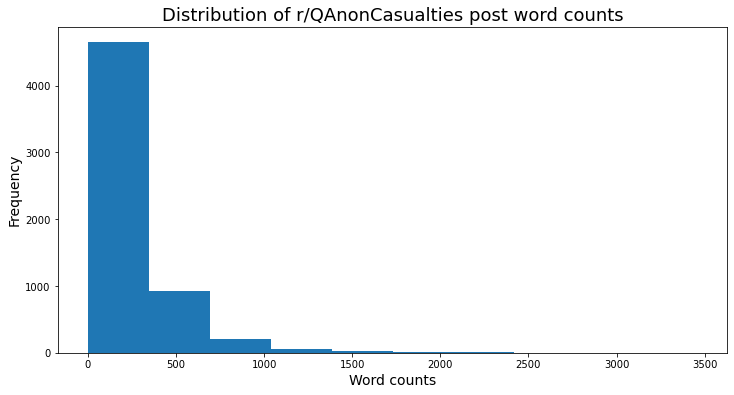

In [15]:
# graph word counts for QAnonCasualties

q_word_counts = qanon.selftext.apply(lambda x: len(x.split()))

print('Average word counts:', q_word_counts.mean())

plt.figure(figsize = (12, 6))

plt.title('Distribution of r/QAnonCasualties post word counts', fontdict=title_dict)
plt.xlabel('Word counts', fontdict=label_dict)
plt.ylabel('Frequency', fontdict=label_dict)
plt.hist(q_word_counts);

In [16]:
# instantiate count vectorizer and fit/transform to the qanon data

cvec = CountVectorizer(stop_words='english', max_features=5000)

qanon_cvec = pd.DataFrame(cvec.fit_transform(qanon.selftext).todense(), 
                          columns = cvec.get_feature_names())

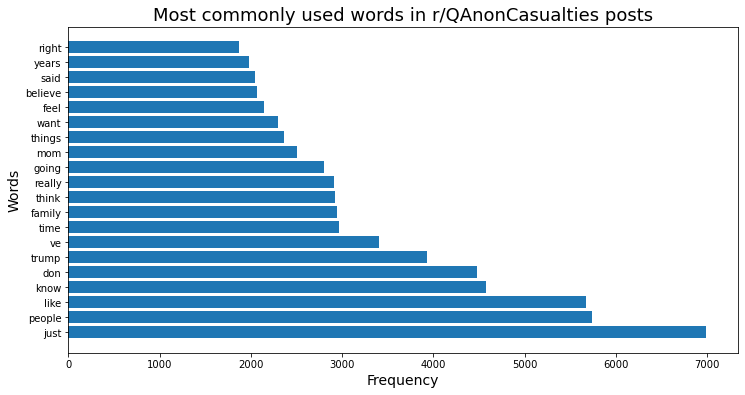

In [17]:
# plot the top 20 most commonly used words for qanon data

plt.figure(figsize = (12,6))

plt.title('Most commonly used words in r/QAnonCasualties posts', fontdict=title_dict)
plt.ylabel('Words', fontdict=label_dict)
plt.xlabel('Frequency', fontdict=label_dict)
plt.barh(qanon_cvec.sum().sort_values(ascending=False)[:20].index,
        qanon_cvec.sum().sort_values(ascending=False)[:20].values);


Average word counts: 248.48386707677463


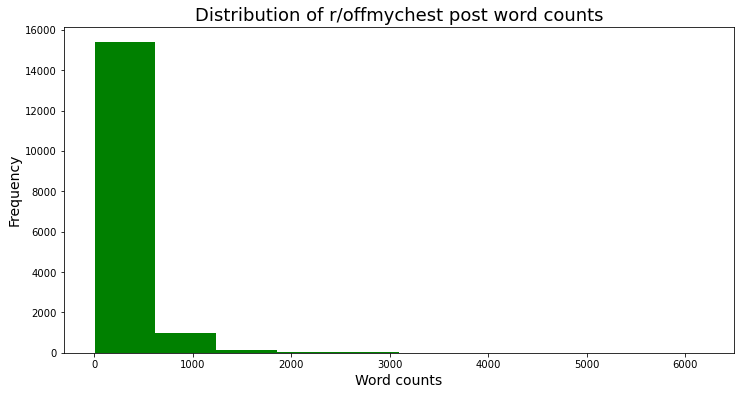

In [18]:
# graph word counts for offmychest

omc_word_counts = omc.selftext.apply(lambda x: len(x.split()))

print('Average word counts:', omc_word_counts.mean())

plt.figure(figsize = (12, 6))

plt.title('Distribution of r/offmychest post word counts', fontdict=title_dict)
plt.xlabel('Word counts', fontdict=label_dict)
plt.ylabel('Frequency', fontdict=label_dict)
plt.hist(omc_word_counts, color = 'g');

In [19]:
# instantiate count vectorizer and fit/transform to the offmychest data

cvec = CountVectorizer(stop_words='english', max_features=5000)

omc_cvec = pd.DataFrame(cvec.fit_transform(omc.selftext).todense(), 
                          columns = cvec.get_feature_names())

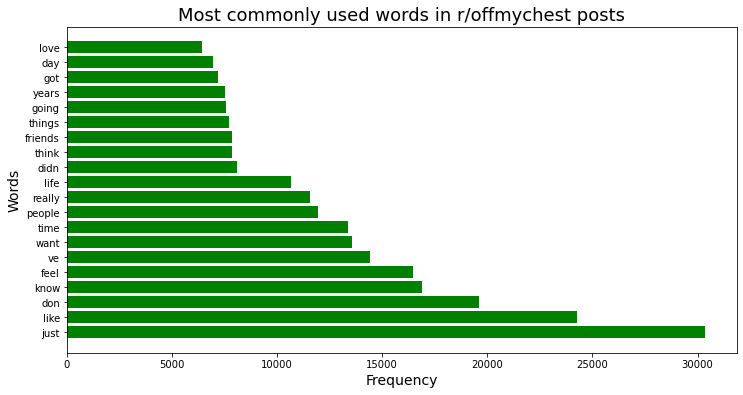

In [20]:
# plot the top 20 most commonly used words for offmychest data

plt.figure(figsize = (12,6))

plt.title('Most commonly used words in r/offmychest posts', fontdict=title_dict)
plt.ylabel('Words', fontdict=label_dict)
plt.xlabel('Frequency', fontdict=label_dict)
plt.barh(omc_cvec.sum().sort_values(ascending=False)[:20].index,
        omc_cvec.sum().sort_values(ascending=False)[:20].values,
        color = 'g');

## Vectorizing unstructured data

In [21]:
# instantiates the Tfidf vectorizer with english stop words

tf = TfidfVectorizer(stop_words='english', strip_accents='unicode', max_features=5000)

# fits the vectorizer to the unstructured data (i.e., the 'selftext' column)

tf.fit(df['selftext'])

# transforms the unstructured data into vectors and 
# returns it as a data frame that can be used for modeling

tfvec = pd.DataFrame(tf.transform(df['selftext']).todense(),
                     columns=tf.get_feature_names())

In [22]:
# sets X = the features (i.e., the vectorized data)
# sets y = the target (i.e., the subreddit)

X = tfvec
y = df['subreddit']

In [23]:
# baseline

y.value_counts(normalize = True)

# baseline accuracy is 0.736737

offmychest         0.736737
QAnonCasualties    0.263263
Name: subreddit, dtype: float64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

## Log Reg

In [25]:
# instantiates the logistic regression

logr = LogisticRegression()

In [26]:
# fit the training data and return the train/test scores for logistic regression

logr.fit(X_train, y_train)

print('Train:', logr.score(X_train, y_train))
print('Test:', logr.score(X_test, y_test))

# logistic regression returns the following scores as the baseline

# Train: 0.9608389122578351
# Test: 0.9489959125644215

Train: 0.9610758931216304
Test: 0.9472187666607429


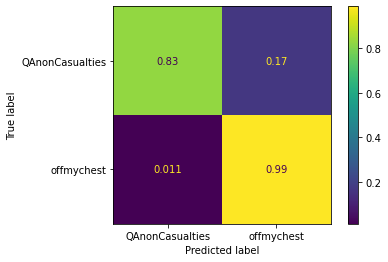

In [27]:
# plot the confusion matrix

metrics.plot_confusion_matrix(logr, X_test, y_test, normalize = 'true');

## Random Forests

In [28]:
# instantiates a random forest classifier

rf = RandomForestClassifier()

In [29]:
# fit the training data to the random forests classifier and
# return the train/test scores

rf.fit(X_train, y_train)

print('Train:', rf.score(X_train, y_train))
print('Test:', rf.score(X_test, y_test))

# Random forests classifier returns the following scores:

# Train: 0.9992298121926655
# Test: 0.9363781766483028
    
# The model is overfit to the training data, but it does not do
# significantly worse than the logistic regression on the test
# data

Train: 0.9992298121926655
Test: 0.9363781766483028


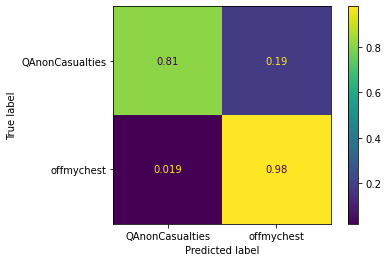

In [30]:
metrics.plot_confusion_matrix(rf, X_test, y_test, normalize='true');

## KNN

In [31]:
# instantiates a K-nearest Neighbors classifier 

knn = KNeighborsClassifier(n_jobs = -1)

In [32]:
# fits the data to X_train and y_train 

knn.fit(X_train, y_train)

# returns the performance of the KNN model for the training
# and the testing data

print('Train score:', knn.score(X_train, y_train))
print('Test score:', knn.score(X_test, y_test))

# Train score: 0.7867172225842763
# Test score: 0.7517327172560867

# KNN performs significantly worse than logistic regression
# and random forests

Train score: 0.8103560637478524
Test score: 0.7522658610271903


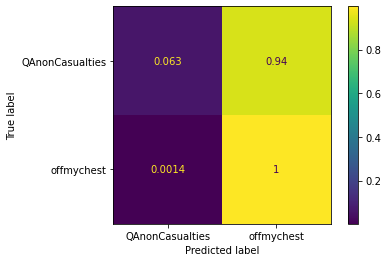

In [33]:
metrics.plot_confusion_matrix(knn, X_test, y_test, normalize='true');